# Chapter 3 Questions

#### 3.1 Form dollar bars for E-mini S&P 500 futures:
1. Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).
2. Use Snippet 3.4 on a pandas series t1, where numDays=1.
3. On those sampled features, apply the triple-barrier method, where ptSl=[1,1] and t1 is the series you created in point 1.b.
4. Apply getBins to generate the labels.

In [54]:
import numpy as np
import pandas as pd

from mlfinlab.corefns.core_functions import CoreFunctions
from mlfinlab.fracdiff.fracdiff import frac_diff_ffd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in data
data = pd.read_csv('official_data/dollar_bars.csv', nrows=20000)
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

In [ ]:
data.head()

**Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).**

In [3]:
# Compute daily volatility
vol = CoreFunctions.get_daily_vol(close=data['close'], lookback=100)

Calculating daily volatility for dynamic thresholds


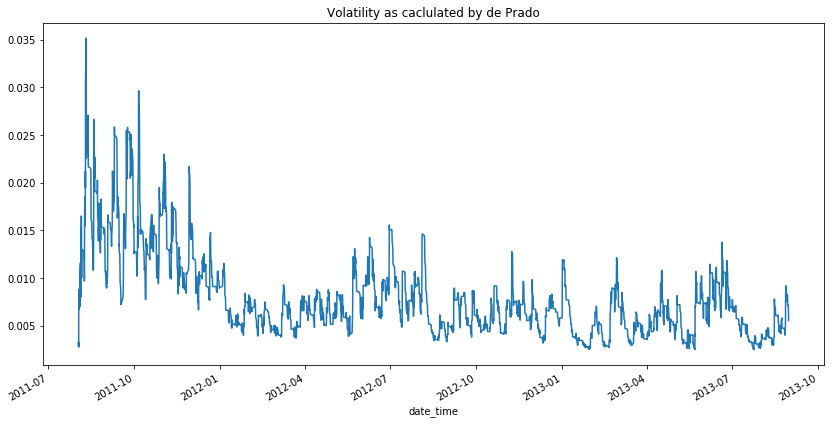

In [4]:
vol.plot(figsize=(14, 7), title='Volatility as caclulated by de Prado')
plt.show()

In [5]:
# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = CoreFunctions.get_t_events(data['close'], threshold=vol.mean())

Applying Symmetric CUSUM filter.


100%|███████████████████████████████████████████████████████████████████████████████| 19998/19998 [00:02<00:00, 6739.76it/s]


**Use Snippet 3.4 on a pandas series t1, where numDays=1.**

In [6]:
# Compute vertical barrier
vertical_barriers = CoreFunctions.add_vertical_barrier(cusum_events, data['close'])
vertical_barriers.head()

2011-08-01 13:46:23.650   2011-08-02 13:50:40.053
2011-08-01 14:01:38.747   2011-08-02 14:04:29.869
2011-08-01 15:38:23.090   2011-08-02 15:49:00.114
2011-08-01 19:25:42.891   2011-08-02 19:26:07.927
2011-08-02 07:31:03.237   2011-08-03 08:02:36.120
Name: date_time, dtype: datetime64[ns]

**On those sampled features, apply the triple-barrier method, where ptSl=[1,1] and t1 is the series you created in point 1.b.**

In [7]:
triple_barrier_events = CoreFunctions.get_events(close=data['close'],
                                  t_events=cusum_events,
                                  pt_sl=[1, 1],
                                  target=vol,
                                  min_ret=0.01,
                                  num_threads=1,
                                  vertical_barrier_times=vertical_barriers,
                                  side=None)

D:\Documents\WQU\Courses\14 - Capstone 690\cs\chapter3\mlfinlab\corefns\core_functions.py:182: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]


In [8]:
triple_barrier_events.head()

,t1,trgt
2011-08-04 01:57:00.466,2011-08-04 10:27:24.326,0.011060
2011-08-04 09:53:01.844,2011-08-04 13:50:40.606,0.011529
2011-08-04 12:43:40.327,2011-08-04 15:01:19.020,0.010884
2011-08-04 19:30:23.101,2011-08-05 06:36:24.009,0.010586
2011-08-04 19:53:02.682,2011-08-05 12:30:19.803,0.012946


In [9]:
labels = CoreFunctions.get_bins(triple_barrier_events, data['close'])

In [10]:
labels.head()

,ret,trgt,bin
2011-08-04 01:57:00.466,-0.016254,0.011060,-1
2011-08-04 09:53:01.844,-0.012014,0.011529,-1
2011-08-04 12:43:40.327,-0.011109,0.010884,-1
2011-08-04 19:30:23.101,-0.012435,0.010586,-1
2011-08-04 19:53:02.682,0.014829,0.012946,1


In [11]:
labels['bin'].value_counts()

 0    201
 1    175
-1    136
Name: bin, dtype: int64

---
#### 3.2 From exercise 1, use Snippet 3.8 to drop rare labels.

In [12]:
clean_labels = CoreFunctions.drop_labels(labels)

In [13]:
print(labels.shape)
print(clean_labels.shape)

(512, 3)
(512, 3)


---
#### 3.3 Adjust the getBins function (Snippet 3.5) to return a 0 whenever the vertical barrier is the one touched first.
This change was made inside the module CoreFunctions.

---
#### 3.4 Develop a trend-following strategy based on a popular technical analysis statistic (e.g., crossing moving averages). For each observation, themodel suggests a side, but not a size of the bet.

1. Derive meta-labels for pt_sl = [1,2] and t1 where num_days=1. Use as trgt the daily standard deviation as computed by Snippet 3.1.
2. Train a random forest to decide whether to trade or not. Note: The decision is whether to trade or not, {0,1}, since the underllying model (the crossing moveing average has decided the side{-1, 1})

First, Build a simple moving average crossover strateggy

In [14]:
close_prices = data['close']
print(len(close_prices))
close_prices.head()

20000


date_time
2011-07-31 23:31:58.810    1305.75
2011-08-01 02:55:17.443    1306.50
2011-08-01 07:25:56.319    1305.00
2011-08-01 08:33:10.903    1300.00
2011-08-01 10:51:41.842    1307.75
Name: close, dtype: float64

Define the window size for crossover lines

In [15]:
fast_window = 20
slow_window = 50

Create a data frame with the close prices and the rolling moving averages

In [16]:
signal_df = close_prices.to_frame()
signal_df['fast_ma'] = signal_df['close'].rolling(window=fast_window, min_periods=1, center=False).mean()
signal_df['slow_ma'] = signal_df['close'].rolling(window=slow_window, min_periods=1, center=False).mean()
signal_df['autocorr'] = signal_df['close'].rolling(window=slow_window, min_periods=1, center=False).mean()
signal_df['side'] = 0.0
signal_df.head()


,close,fast_ma,slow_ma,side
date_time,,,,
2011-07-31 23:31:58.810,1305.75,1305.7500,1305.7500,0.0
2011-08-01 02:55:17.443,1306.50,1306.1250,1306.1250,0.0
2011-08-01 07:25:56.319,1305.00,1305.7500,1305.7500,0.0
2011-08-01 08:33:10.903,1300.00,1304.3125,1304.3125,0.0
2011-08-01 10:51:41.842,1307.75,1305.0000,1305.0000,0.0


Create a side when the short MA crosses over the long MA. Ensure that this is done for the period that is larger than the shortest MA window


In [17]:
# compute sides
signal_df['side'][fast_window:] = np.where(signal_df['fast_ma'][fast_window:] >= 
                                           signal_df['slow_ma'][fast_window:], 1.0, -1.0) 

print(signal_df.side.value_counts())

 1.0    10742
-1.0     9238
 0.0       20
Name: side, dtype: int64


In [19]:
print(signal_df.head())
print(signal_df.tail())

                           close    fast_ma    slow_ma  side
date_time                                                   
2011-07-31 23:31:58.810  1305.75  1305.7500  1305.7500   0.0
2011-08-01 02:55:17.443  1306.50  1306.1250  1306.1250   0.0
2011-08-01 07:25:56.319  1305.00  1305.7500  1305.7500   0.0
2011-08-01 08:33:10.903  1300.00  1304.3125  1304.3125   0.0
2011-08-01 10:51:41.842  1307.75  1305.0000  1305.0000   0.0
                           close    fast_ma   slow_ma  side
date_time                                                  
2013-08-30 19:59:51.155  1630.75  1630.6625  1633.805  -1.0
2013-08-30 19:59:59.085  1629.25  1630.5875  1633.610  -1.0
2013-08-30 20:00:02.187  1631.00  1630.5750  1633.400  -1.0
2013-08-30 20:02:23.500  1632.25  1630.6375  1633.230  -1.0
2013-08-30 20:34:18.899  1631.75  1630.6500  1633.070  -1.0


In [21]:
# extract side as a series
side = signal_df['side']

On those sampled features, apply the triple-barrier method, where ptSl=[1,2] and t1 earlier

In [22]:
# Compute daily volatility
# vol = CoreFunctions.get_daily_vol(close=close_prices, lookback=100)

# Apply Symmetric CUSUM Filter and get timestamps for events
# cusum_events = CoreFunctions.get_t_events(close_prices, threshold=vol.mean())

# Compute vertical barrier
# vertical_barriers = CoreFunctions.add_vertical_barrier(cusum_events, close_prices)

ma_events = CoreFunctions.get_events(close_prices,                                     
                                     t_events=cusum_events,
                                     pt_sl=[1, 2],
                                     target=vol,
                                     min_ret=0.01,
                                     num_threads=1,
                                     vertical_barrier_times=vertical_barriers,
                                     side=side)


D:\Documents\WQU\Courses\14 - Capstone 690\cs\chapter3\mlfinlab\corefns\core_functions.py:182: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]


In [23]:
print(ma_events.head())
print(ma_events.side.value_counts())

                         side                      t1      trgt
2011-08-04 01:57:00.466   1.0 2011-08-04 14:12:16.878  0.011060
2011-08-04 09:53:01.844   1.0 2011-08-04 15:43:40.842  0.011529
2011-08-04 12:43:40.327   1.0 2011-08-04 18:27:50.147  0.010884
2011-08-04 19:30:23.101  -1.0 2011-08-05 06:36:24.009  0.010586
2011-08-04 19:53:02.682  -1.0 2011-08-05 15:16:11.831  0.012946
 1.0    257
-1.0    255
Name: side, dtype: int64


In [24]:
labels = CoreFunctions.get_bins(ma_events, close_prices)

In [27]:
print(labels.head())
labels.bin.value_counts()

                              ret      trgt  bin
2011-08-04 01:57:00.466 -0.022597  0.011060    0
2011-08-04 09:53:01.844 -0.023228  0.011529    0
2011-08-04 12:43:40.327 -0.022824  0.010884    0
2011-08-04 19:30:23.101  0.012435  0.010586    1
2011-08-04 19:53:02.682  0.014620  0.012946    1


0    334
1    178
Name: bin, dtype: int64

(3.4b) Train a random forest to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1) 

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix

In [36]:
# create additional features
def get_autocorr(close, lookback=100):
    """
    Daily Autocorr Estimates

    See the pandas documentation for details on the pandas.Series.ewm function.

    :param close: (data frame) Closing prices
    :param lookback: (int) lookback period to compute volatility
    :return: (series) of daily volatility value
    """
    print('Calculating daily volatility for dynamic thresholds')
        
    # daily vol re-indexed to close
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]))
        
    df0 = close.loc[df0.index] / close.loc[df0.values].values - 1  # daily returns
    # df0 = df0.ewm(span=lookback).autocorr()
    df0 = df0.rolling(lookback).apply(lambda x: x.autocorr(), raw=False)
    return df0


In [40]:
# compute auto-correlation
auto_corr = get_autocorr(close_prices)

Calculating daily volatility for dynamic thresholds


In [41]:
len(auto_corr)

19945

In [74]:
# compute fractionally differentiated prices
from statsmodels.tsa.stattools import adfuller

fracs = frac_diff_ffd(close_prices.apply(np.log), differencing_amt=0.39, threshold=1e-5)
result = adfuller(fracs, maxlag=2, regression='C', autolag='AIC', store=False, regresults=False)
print('ADF Statistic: %f' % abs(round(result[0], 3)))
print('p-value: %f' % result[1])
print('Critical values:')
for k, v in result[4].items():
    print('\t%s: %.3f' % (k, v))

frac_df = pd.Series(index=close_prices.index, data=fracs).rename('fracdiff')
frac_df.tail()

ADF Statistic: 3.516000
p-value: 0.007574
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


date_time
2013-08-30 19:59:51.155    0.288143
2013-08-30 19:59:59.085    0.287063
2013-08-30 20:00:02.187    0.288437
2013-08-30 20:02:23.500    0.288869
2013-08-30 20:34:18.899    0.288184
Name: fracdiff, dtype: float64

In [80]:
# Create feature matrix
X = pd.DataFrame(labels['trgt'])
X['side'] = [ma_events['side'][x] for x in X.index]
X['autocorr'] = [auto_corr[x] for x in X.index]
X['fast_ma'] = [signal_df['fast_ma'][x] for x in X.index]
X['slow_ma'] = [signal_df['slow_ma'][x] for x in X.index]
X['fracdiff'] = [frac_df[x] for x in X.index]
print(X.tail())

                             trgt  side  autocorr    fast_ma   slow_ma  \
2013-06-21 07:09:37.942  0.011954  -1.0  0.975765  1583.0875  1590.175   
2013-06-21 14:31:34.774  0.011097   1.0  0.968678  1589.8500  1587.230   
2013-06-24 03:22:10.088  0.010504   1.0  0.981188  1584.6750  1581.755   
2013-06-25 19:33:49.301  0.011368   1.0  0.979041  1579.4250  1576.015   
2013-06-26 12:26:25.424  0.010686   1.0  0.980111  1582.3500  1578.950   

                         fracdiff  
2013-06-21 07:09:37.942  0.290053  
2013-06-21 14:31:34.774  0.283423  
2013-06-24 03:22:10.088  0.281016  
2013-06-25 19:33:49.301  0.289833  
2013-06-26 12:26:25.424  0.291114  


In [83]:
# extract y values
y = labels.bin.to_frame()

C:\Users\Asingh\Anaconda3\envs\p36\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


              precision    recall  f1-score   support

           0       0.72      0.46      0.56       282
           1       0.33      0.59      0.43       128

   micro avg       0.50      0.50      0.50       410
   macro avg       0.53      0.53      0.50       410
weighted avg       0.60      0.50      0.52       410

Confusion Matrix
[[131 151]
 [ 52  76]]


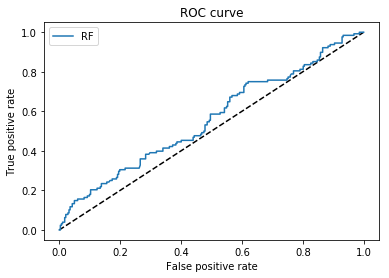

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, shuffle=False)

n_estimator = 10_000
c_random_state = 777

rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train, y_train)
# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
